# Guia do Projeto - Tech Challenge Fase 4 - Parte 06

## Pipeline Final: Módulo de Análise de Vídeo

Este notebook representa a consolidação de todo o trabalho desenvolvido. Aqui, apresentamos o **Módulo de Análise de Vídeo** completo, capaz de receber um arquivo de vídeo bruto e gerar um relatório detalhado sobre as cenas, pessoas, emoções e atividades detectadas.

### O Que Este Módulo Faz?

1.  **Recebe um Vídeo**: Qualquer arquivo MP4, AVI, etc.
2.  **Detecta Cenas**: Segmenta o vídeo em partes lógicas.
3.  **Analisa Conteúdo**: Para cada cena, detecta rostos, emoções e atividades.
4.  **Gera Relatório**: Cria uma tabela resumo e uma galeria visual das cenas.

### Independência do Código
Para garantir que este notebook funcione de forma independente (standalone), todo o código necessário (classes e funções desenvolvidas nos notebooks 01 a 05) está incluído na primeira célula de código abaixo.

In [2]:
import cv2
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Dict, Deque, Any, Generator
from collections import deque, Counter
from ultralytics import YOLO
from deepface import DeepFace
from datetime import timedelta
import logging

# Suprimir logs excessivos
os.environ["YOLO_VERBOSE"] = "False"
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ==========================================
# 1. MODELOS DE DADOS (Data Classes)
# ==========================================

@dataclass
class BoundingBox:
    x: int; y: int; width: int; height: int

@dataclass
class FaceDetection:
    bounding_box: BoundingBox; confidence: float

@dataclass
class EmotionAnalysis:
    emotion: str; confidence: float

@dataclass
class ActivityDetection:
    activity: str; confidence: float; track_id: Optional[int] = None

@dataclass
class Scene:
    scene_id: int
    start_frame: int
    end_frame: int
    start_time: float
    end_time: float
    @property
    def duration_seconds(self) -> float: return self.end_time - self.start_time

@dataclass
class SceneResult:
    scene: Scene
    unique_faces: int = 0
    dominant_emotions: Dict[str, int] = field(default_factory=dict)
    dominant_actions: Dict[str, int] = field(default_factory=dict)

# ==========================================
# 2. DETECTORES E ANALISADORES (Core Logic)
# ==========================================

class FaceDetector:
    def __init__(self, model_path: str = "yolo11n-pose.pt", confidence_threshold: float = 0.5):
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold

    def detect(self, frame) -> List[FaceDetection]:
        results = self.model(frame, conf=self.confidence_threshold, verbose=False)
        faces = []
        frame_height, frame_width = frame.shape[:2]

        for result in results:
            if result.keypoints is None: continue
            keypoints = result.keypoints.data
            for person_keypoints in keypoints:
                # Simplificação: Usar keypoints do rosto (nariz, olhos) para estimar a caixa
                face_kps = person_keypoints[:3]
                if face_kps[0][2] > 0.5: # Se nariz visível
                    x_min = int(face_kps[:, 0].min())
                    y_min = int(face_kps[:, 1].min())
                    x_max = int(face_kps[:, 0].max())
                    y_max = int(face_kps[:, 1].max())
                    w = x_max - x_min
                    h = y_max - y_min
                    pad = int(w * 0.5)
                    
                    faces.append(FaceDetection(
                        bounding_box=BoundingBox(
                            x=max(0, x_min - pad), 
                            y=max(0, y_min - pad), 
                            width=w + 2*pad, 
                            height=h + 2*pad
                        ),
                        confidence=0.9
                    ))
        return faces

class EmotionAnalyzer:
    def analyze(self, frame: np.ndarray, faces: List[FaceDetection]) -> List[EmotionAnalysis]:
        emotions = []
        for face in faces:
            bbox = face.bounding_box
            x, y = max(0, bbox.x), max(0, bbox.y)
            x_end, y_end = min(frame.shape[1], x + bbox.width), min(frame.shape[0], y + bbox.height)
            face_img = frame[y:y_end, x:x_end]
            
            if face_img.size == 0:
                emotions.append(EmotionAnalysis("unknown", 0.0))
                continue

            try:
                result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False, detector_backend='skip', silent=True)
                if isinstance(result, list): result = result[0]
                dom = result['dominant_emotion']
                conf = result['emotion'][dom] / 100.0
                emotions.append(EmotionAnalysis(dom, conf))
            except:
                emotions.append(EmotionAnalysis("unknown", 0.0))
        return emotions

class ActivityDetector:
    def __init__(self, model_path: str = "yolo11n-pose.pt"):
        self.model = YOLO(model_path)
        self.track_history = {}

    def detect(self, frame: np.ndarray) -> List[ActivityDetection]:
        results = self.model.track(frame, persist=True, verbose=False, tracker="bytetrack.yaml")
        activities = []
        
        for result in results:
            if result.boxes is None or result.keypoints is None: continue
            boxes = result.boxes
            keypoints = result.keypoints.data
            
            for i, kps in enumerate(keypoints):
                track_id = int(boxes.id[i].item()) if boxes.id is not None else -1
                
                # Lógica Heurística Simplificada
                nose = kps[0]
                l_wrist, r_wrist = kps[9], kps[10]
                l_shoulder, r_shoulder = kps[5], kps[6]
                
                activity = "standing"
                if (l_wrist[2]>0.5 and l_shoulder[2]>0.5 and l_wrist[1] < l_shoulder[1]) or \
                   (r_wrist[2]>0.5 and r_shoulder[2]>0.5 and r_wrist[1] < r_shoulder[1]):
                    activity = "waving"
                elif nose[2]>0.5 and ((l_wrist[2]>0.5 and np.linalg.norm(l_wrist[:2]-nose[:2])<50) or \
                                      (r_wrist[2]>0.5 and np.linalg.norm(r_wrist[:2]-nose[:2])<50)):
                    activity = "talking"
                
                activities.append(ActivityDetection(activity, 0.8, track_id))
        return activities

class SceneDetector:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
    
    def detect_scenes(self, video_path: str) -> List[Scene]:
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        scenes = []
        scene_start = 0
        scene_id = 1
        
        ret, prev = cap.read()
        if not ret: return []
        prev_hist = cv2.calcHist([prev], [0], None, [256], [0, 256])
        cv2.normalize(prev_hist, prev_hist, 0, 1, cv2.NORM_MINMAX)
        
        frame_num = 1
        while True:
            ret, curr = cap.read()
            if not ret: break
            curr_hist = cv2.calcHist([curr], [0], None, [256], [0, 256])
            cv2.normalize(curr_hist, curr_hist, 0, 1, cv2.NORM_MINMAX)
            score = cv2.compareHist(prev_hist, curr_hist, cv2.HISTCMP_CORREL)
            
            if score < self.threshold:
                scenes.append(Scene(scene_id, scene_start, frame_num-1, scene_start/fps, (frame_num-1)/fps))
                scene_id += 1
                scene_start = frame_num
            prev_hist = curr_hist
            frame_num += 1
            
        scenes.append(Scene(scene_id, scene_start, frame_num-1, scene_start/fps, (frame_num-1)/fps))
        cap.release()
        return scenes

# ==========================================
# 3. ORQUESTRADOR (Pipeline Principal)
# ==========================================

class VideoSceneAnalyzer:
    def __init__(self, video_path, scene_threshold=0.5, sample_rate=5):
        self.video_path = video_path
        self.sample_rate = sample_rate
        self.scene_detector = SceneDetector(scene_threshold)
        self.face_detector = FaceDetector()
        self.emotion_analyzer = EmotionAnalyzer()
        self.activity_detector = ActivityDetector()
        
    def analyze(self) -> List[SceneResult]:
        print("1. Detectando cenas...")
        scenes = self.scene_detector.detect_scenes(self.video_path)
        print(f"   -> {len(scenes)} cenas encontradas.")
        
        results = []
        cap = cv2.VideoCapture(self.video_path)
        
        for scene in scenes:
            print(f"2. Analisando Cena {scene.scene_id}...")
            cap.set(cv2.CAP_PROP_POS_FRAMES, scene.start_frame)
            emotions_cnt = Counter()
            actions_cnt = Counter()
            unique_faces = set()
            
            curr = scene.start_frame
            while curr <= scene.end_frame:
                ret, frame = cap.read()
                if not ret: break
                
                if (curr - scene.start_frame) % self.sample_rate == 0:
                    # Atividades
                    acts = self.activity_detector.detect(frame)
                    for a in acts:
                        actions_cnt[a.activity] += 1
                        if a.track_id: unique_faces.add(a.track_id)
                    
                    # Emoções
                    faces = self.face_detector.detect(frame)
                    ems = self.emotion_analyzer.analyze(frame, faces)
                    for e in ems: emotions_cnt[e.emotion] += 1
                
                curr += 1
            
            results.append(SceneResult(
                scene, 
                len(unique_faces), 
                dict(emotions_cnt.most_common(3)), 
                dict(actions_cnt.most_common(3))
            ))
        cap.release()
        return results

### 4. Execução do Pipeline

Agora, vamos rodar o sistema completo no nosso vídeo de exemplo.

In [7]:
video_path = "meu_video.mp4"

if os.path.exists(video_path):
    analyzer = VideoSceneAnalyzer(video_path, scene_threshold=0.6, sample_rate=10)
    results = analyzer.analyze()
else:
    print(f"Vídeo {video_path} não encontrado. Certifique-se de fazer o upload.")
    results = []

1. Detectando cenas...
   -> 18 cenas encontradas.
2. Analisando Cena 1...
   -> 18 cenas encontradas.
2. Analisando Cena 1...
2. Analisando Cena 2...
2. Analisando Cena 2...
2. Analisando Cena 3...
2. Analisando Cena 3...
2. Analisando Cena 4...
2. Analisando Cena 4...
2. Analisando Cena 5...
2. Analisando Cena 5...
2. Analisando Cena 6...
2. Analisando Cena 6...
2. Analisando Cena 7...
2. Analisando Cena 7...
2. Analisando Cena 8...
2. Analisando Cena 8...
2. Analisando Cena 9...
2. Analisando Cena 9...
2. Analisando Cena 10...
2. Analisando Cena 10...
2. Analisando Cena 11...
2. Analisando Cena 11...
2. Analisando Cena 12...
2. Analisando Cena 12...
2. Analisando Cena 13...
2. Analisando Cena 13...
2. Analisando Cena 14...
2. Analisando Cena 14...
2. Analisando Cena 15...
2. Analisando Cena 15...
2. Analisando Cena 16...
2. Analisando Cena 16...
2. Analisando Cena 17...
2. Analisando Cena 17...
2. Analisando Cena 18...
2. Analisando Cena 18...


### 5. Relatório Final

Apresentamos os resultados em formato tabular e visual.

In [4]:
if results:
    report_data = []
    for res in results:
        scene = res.scene
        emotions_str = ", ".join([f"{k}({v})" for k, v in res.dominant_emotions.items()])
        actions_str = ", ".join([f"{k}({v})" for k, v in res.dominant_actions.items()])
        
        report_data.append({
            "Cena": scene.scene_id,
            "Início": str(timedelta(seconds=int(scene.start_time))),
            "Fim": str(timedelta(seconds=int(scene.end_time))),
            "Duração": f"{scene.duration_seconds:.1f}s",
            "Pessoas": res.unique_faces,
            "Emoções": emotions_str,
            "Ações": actions_str
        })

    df = pd.DataFrame(report_data)
    print("=== RELATÓRIO DE ANÁLISE DE VÍDEO ===")
    display(df)
    
    # Salvar CSV
    df.to_csv("relatorio_final.csv", index=False)
    print("Relatório salvo como 'relatorio_final.csv'")

=== RELATÓRIO DE ANÁLISE DE VÍDEO ===


Cena   Início      Fim Duração  Pessoas                           Emoções  \
0      1  0:00:00  0:00:05    6.0s        4       sad(35), fear(12), happy(9)   
1      2  0:00:06  0:00:11    6.0s        1         sad(7), fear(6), happy(2)   
2      3  0:00:12  0:00:17    6.0s        0                                     
3      4  0:00:18  0:00:23    6.0s        1      sad(6), neutral(3), happy(3)   
4      5  0:00:24  0:00:29    6.0s        1                         happy(18)   
5      6  0:00:30  0:00:35    6.0s        1                          fear(18)   
6      7  0:00:36  0:00:41    6.0s        1                happy(16), fear(2)   
7      8  0:00:42  0:00:47    6.0s        1       fear(7), sad(4), neutral(4)   
8      9  0:00:48  0:00:53    6.0s        1         sad(7), fear(6), happy(4)   
9     10  0:00:54  0:00:56    3.0s        1               neutral(6), fear(3)   
10    11  0:00:57  0:01:00    4.0s        1  fear(9), neutral(2), surprise(1)   
11    12  0:01:01  0:01:06    6.0s        2        fear(12), sad(3), happy(2)   
12    13  0:01:07  0:01:18   12.0s        4    neutral(28), fear(20), sad(11)   
13    14  0:01:19  0:01:19    1.0s        1                 angry(2), fear(1)   
14    15  0:01:20  0:01:31   12.0s        6    sad(39), fear(33), neutral(24)   
15    16  0:01:32  0:01:37    6.0s        2               neutral(6), fear(4)   
16    17  0:01:38  0:01:49   12.0s       10    fear(23), sad(22), neutral(17)   
17    18  0:01:50  0:01:50    0.8s        1                   fear(2), sad(1)   

                                   Ações  
0                           standing(72)  
1                standing(15), waving(3)  
2                                         
3                waving(12), standing(6)  
4                           standing(18)  
5                standing(14), waving(4)  
6                             waving(18)  
7                           standing(18)  
8                           standing(18)  
9                            standing(9)  
10                          standing(12)  
11               standing(28), waving(4)  
12   standing(66), talking(1), waving(1)  
13                           standing(3)  
14  standing(86), waving(32), talking(5)  
15                          standing(20)  
16                         standing(134)  
17                           standing(3)

Relatório salvo como 'relatorio_final.csv'


### 6. Galeria Visual das Cenas

Para facilitar a validação, mostramos um frame representativo de cada cena.

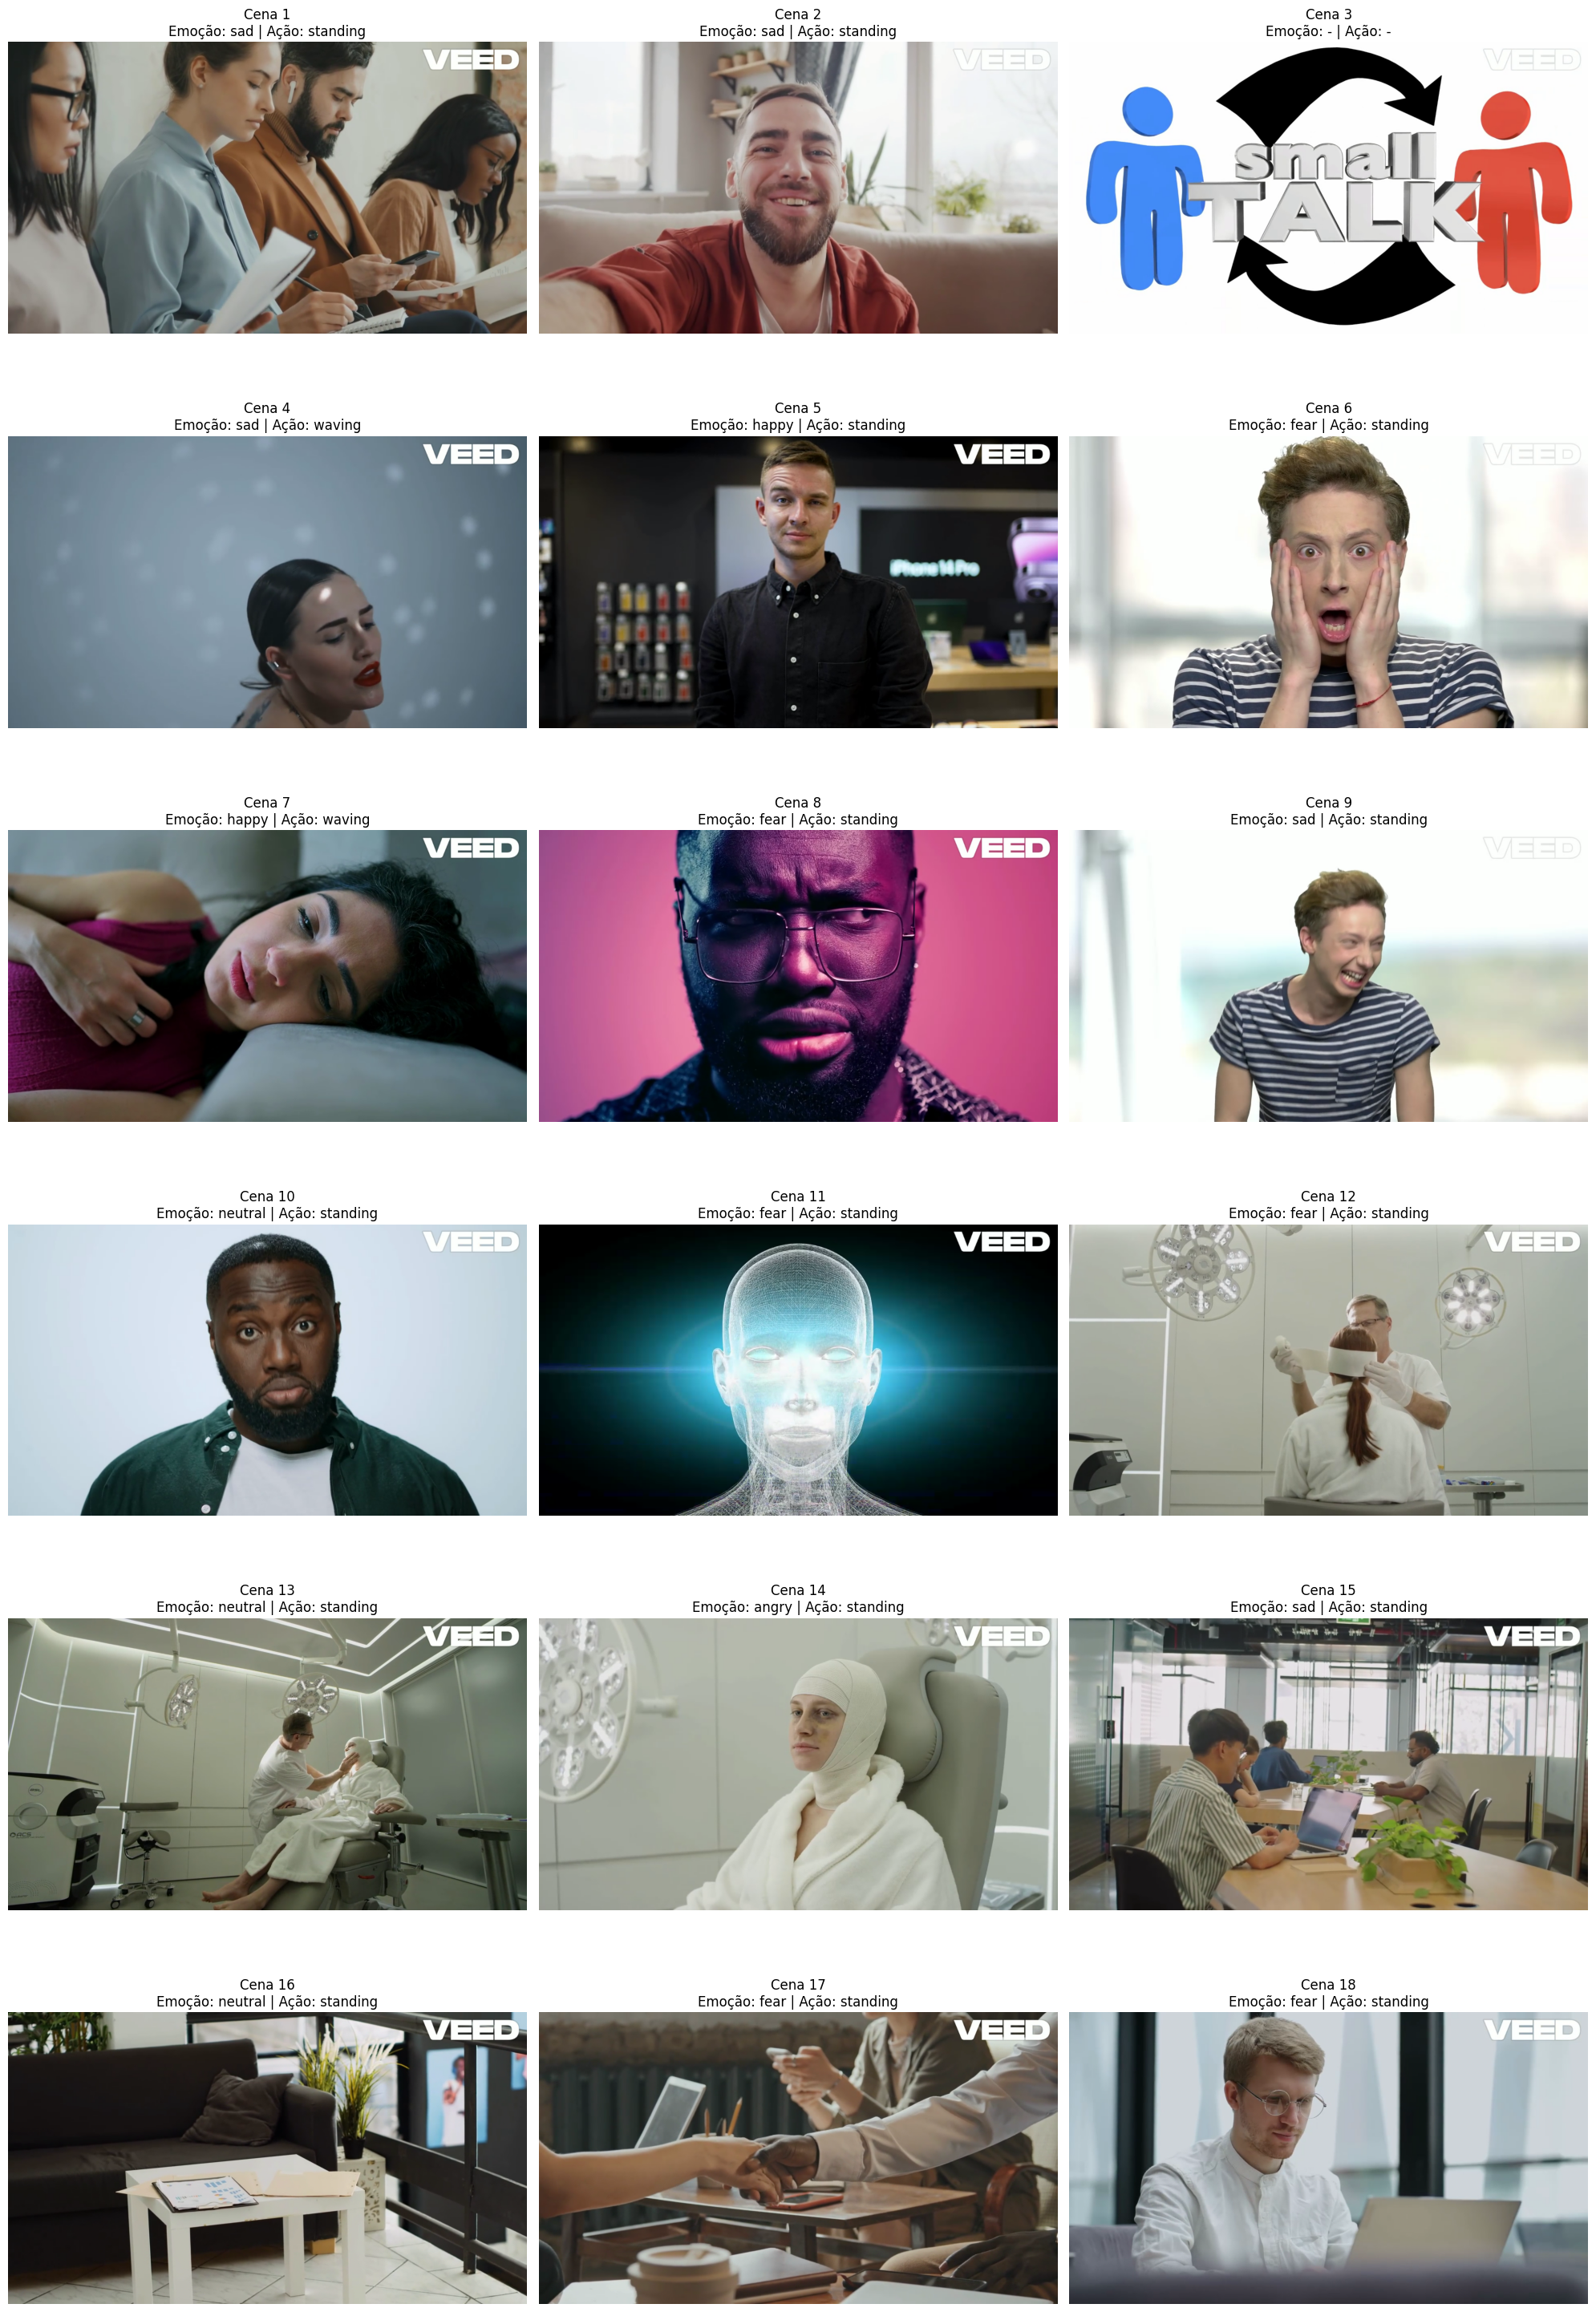

In [5]:
def visualize_scenes(video_path, results):
    if not results: return
    
    num_scenes = len(results)
    cols = 3
    rows = math.ceil(num_scenes / cols)
    
    plt.figure(figsize=(20, 5 * rows))
    cap = cv2.VideoCapture(video_path)
    
    for i, res in enumerate(results):
        scene = res.scene
        mid_frame = (scene.start_frame + scene.end_frame) // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            top_emotion = list(res.dominant_emotions.keys())[0] if res.dominant_emotions else "-"
            top_action = list(res.dominant_actions.keys())[0] if res.dominant_actions else "-"
            
            plt.subplot(rows, cols, i + 1)
            plt.imshow(frame_rgb)
            plt.title(f"Cena {scene.scene_id}\nEmoção: {top_emotion} | Ação: {top_action}")
            plt.axis('off')
            
    cap.release()
    plt.tight_layout()
    plt.show()

if results:
    visualize_scenes(video_path, results)

### 7. Geração de Vídeo com Anotações Visuais (Bounding Boxes, Keypoints e Skeleton)

Esta seção tem a funcionalidade de gerar um vídeo de saída com todas as anotações visuais:
- **Bounding boxes roxos** para faces detectadas com labels de emoções
- **Skeleton verde** com keypoints das poses corporais
- **Labels de atividades** (standing, sitting, lying_down)
- **Detecção de anomalias** (movimentos bruscos)
- **Detecção de mudanças de cena**

In [8]:
from tqdm import tqdm

# ==========================================
# GERAÇÃO DE VÍDEO ANOTADO
# Utilizando as classes já definidas no notebook
# ==========================================

def detect_activity_from_keypoints(keypoints):
    """
    Detecta atividade baseada nos keypoints do corpo (como em combined_detection.py).
    
    Args:
        keypoints: Array de keypoints no formato COCO (17 pontos)
        
    Returns:
        str: Atividade detectada ('standing', 'sitting', 'lying_down', 'unknown')
    """
    if len(keypoints) < 17:
        return "unknown"
    
    # Keypoints COCO: 0-nose, 5-left_shoulder, 6-right_shoulder, 11-left_hip, 12-right_hip
    # 13-left_knee, 14-right_knee, 15-left_ankle, 16-right_ankle
    
    shoulders = keypoints[5:7]
    hips = keypoints[11:13]
    knees = keypoints[13:15]
    
    # Verificar se keypoints principais estão visíveis
    if not all(k[0] > 0 and k[1] > 0 for k in [shoulders[0], shoulders[1], hips[0], hips[1]]):
        return "unknown"
    
    # Calcular posições médias
    shoulder_y = (shoulders[0][1] + shoulders[1][1]) / 2
    shoulder_x = (shoulders[0][0] + shoulders[1][0]) / 2
    hip_y = (hips[0][1] + hips[1][1]) / 2
    hip_x = (hips[0][0] + hips[1][0]) / 2
    
    # Distância vertical entre ombros e quadris (altura do torso)
    torso_height = abs(shoulder_y - hip_y)
    
    # Alinhamento horizontal (corpo ereto vs inclinado)
    horizontal_offset = abs(shoulder_x - hip_x)
    
    # Diferença de altura entre ombros (detectar deitado)
    shoulder_tilt = abs(shoulders[0][1] - shoulders[1][1])
    
    # Verificar joelhos
    knees_visible = knees[0][0] > 0 and knees[1][0] > 0
    
    hip_to_knee = 0
    if knees_visible:
        knee_y = (knees[0][1] + knees[1][1]) / 2
        hip_to_knee = knee_y - hip_y
    
    # CRITÉRIO 1: EM PÉ
    if torso_height > 120:
        if torso_height > 150:
            return "standing"
        if knees_visible:
            if hip_to_knee > 70:
                return "standing"
            if hip_to_knee < 50 and torso_height < 140:
                return "sitting"
        return "standing"
    
    # CRITÉRIO 2: SENTADO
    if torso_height < 120:
        if torso_height < 80:
            return "sitting"
        if knees_visible and hip_to_knee < 80:
            return "sitting"
        return "sitting"
    
    # CRITÉRIO 3: DEITADO
    if shoulder_tilt > 60 and torso_height < 60 and horizontal_offset < 40:
        return "lying_down"
    
    return "standing"


def generate_annotated_video(video_path, output_path, confidence_threshold=0.5):
    """
    Gera um vídeo com anotações visuais completas.
    
    Funcionalidades:
    - Bounding boxes para faces (roxo)
    - Labels de emoções detectadas
    - Skeleton com keypoints (verde/vermelho)
    - Labels de atividades junto à pessoa
    - Detecção de anomalias
    - Detecção de mudanças de cena
    
    Args:
        video_path: Caminho do vídeo de entrada
        output_path: Caminho do vídeo de saída
        confidence_threshold: Limiar de confiança para detecções
    """
    # Inicializar detectores usando as classes já definidas
    face_detector = FaceDetector(confidence_threshold=confidence_threshold)
    emotion_analyzer = EmotionAnalyzer()
    scene_detector = SceneDetector(threshold=0.4)
    
    # Inicializar YOLO Pose diretamente para controle completo dos keypoints
    yolo_pose = YOLO('yolo11n-pose.pt')
    
    # Contadores de estatísticas
    emotion_counter = Counter()
    activity_counter = Counter()
    anomaly_count = 0
    
    # Estado para tracking e estabilização
    previous_keypoints = {}
    
    # Configurações
    anomaly_threshold = 100  # Limiar para movimento brusco
    
    # Conexões do skeleton (formato COCO)
    skeleton_connections = [
        [16, 14], [14, 12], [17, 15], [15, 13], [12, 13],
        [6, 12], [7, 13], [6, 7], [6, 8], [7, 9],
        [8, 10], [9, 11], [2, 3], [1, 2], [1, 3],
        [2, 4], [3, 5], [4, 6], [5, 7]
    ]

    # Abrir vídeo
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Erro ao abrir o vídeo: {video_path}")
        return

    # Propriedades do vídeo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Detectar cenas usando SceneDetector
    print("Detectando cenas...")
    scenes = scene_detector.detect_scenes(video_path)
    scene_frames = set()
    for scene in scenes:
        scene_frames.add(scene.start_frame)
    print(f"   -> {len(scenes)} cenas encontradas.")

    # Configurar VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"\nProcessando vídeo: {video_path}")
    print(f"Dimensões: {width}x{height}, FPS: {fps}, Total de frames: {total_frames}")

    # Processar cada frame
    for frame_idx in tqdm(range(total_frames), desc="Gerando vídeo anotado"):
        ret, frame = cap.read()
        if not ret:
            break

        # Verificar se é início de nova cena (resetar tracking de anomalias)
        if frame_idx in scene_frames:
            previous_keypoints.clear()

        # 1. Detectar poses com YOLO e processar cada pessoa
        yolo_results = yolo_pose(frame, conf=confidence_threshold, verbose=False)
        
        for result in yolo_results:
            if result.keypoints is not None and len(result.keypoints.xy) > 0:
                for person_idx, person_kpts in enumerate(result.keypoints.xy):
                    kpts = person_kpts.cpu().numpy()
                    
                    # Detectar anomalias (movimentos bruscos)
                    if person_idx in previous_keypoints:
                        prev_kpts = previous_keypoints[person_idx]
                        valid_movements = []
                        for curr, prev in zip(kpts, prev_kpts):
                            if curr[0] > 0 and curr[1] > 0 and prev[0] > 0 and prev[1] > 0:
                                movement = np.sqrt((curr[0] - prev[0])**2 + (curr[1] - prev[1])**2)
                                valid_movements.append(movement)
                        
                        if valid_movements:
                            max_movement = np.max(valid_movements)
                            if max_movement > anomaly_threshold:
                                anomaly_count += 1
                    
                    previous_keypoints[person_idx] = kpts.copy()
                    
                    # Detectar atividade baseada nos keypoints
                    activity = detect_activity_from_keypoints(kpts)
                    activity_counter[activity] += 1
                    
                    # Desenhar skeleton (verde)
                    for connection in skeleton_connections:
                        pt1_idx, pt2_idx = connection[0] - 1, connection[1] - 1
                        if pt1_idx < len(kpts) and pt2_idx < len(kpts):
                            pt1, pt2 = kpts[pt1_idx], kpts[pt2_idx]
                            if pt1[0] > 0 and pt1[1] > 0 and pt2[0] > 0 and pt2[1] > 0:
                                cv2.line(frame, (int(pt1[0]), int(pt1[1])), 
                                        (int(pt2[0]), int(pt2[1])), (0, 255, 0), 2)
                    
                    # Desenhar keypoints (vermelho)
                    for x, y in kpts:
                        if x > 0 and y > 0:
                            cv2.circle(frame, (int(x), int(y)), 4, (0, 0, 255), -1)
                    
                    # Mostrar label de atividade JUNTO À PESSOA (acima do nariz)
                    if activity != "unknown":
                        nose = kpts[0]  # Keypoint 0 = nariz
                        if nose[0] > 0 and nose[1] > 0:
                            cv2.putText(frame, activity, 
                                       (int(nose[0]) - 30, int(nose[1]) - 30), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

        # 2. Detectar faces usando FaceDetector
        faces = face_detector.detect(frame)
        
        # 3. Analisar emoções usando EmotionAnalyzer
        emotions = emotion_analyzer.analyze(frame, faces)
        
        # Desenhar bounding boxes e labels
        for face, emotion in zip(faces, emotions):
            bbox = face.bounding_box
            x, y, w, h = bbox.x, bbox.y, bbox.width, bbox.height
            
            # Desenhar bounding box (roxo)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
            
            # Contabilizar emoção
            emotion_counter[emotion.emotion] += 1
            
            # Posicionar label de emoção
            if h > (height * 0.6):
                text_x, text_y = x + w + 10, y + h // 2
            else:
                text_x, text_y = x, max(10, y - 10)
            
            # Label com emoção e confiança
            label = f"{emotion.emotion} ({emotion.confidence:.0%})"
            cv2.putText(frame, label, (text_x, text_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36, 255, 12), 2)

        out.write(frame)

    cap.release()
    out.release()
    
    # Imprimir resumo
    duration = total_frames / fps if fps > 0 else 0
    
    print("\n" + "="*60)
    print("VÍDEO ANOTADO GERADO COM SUCESSO")
    print("="*60)
    print(f"Duração: {duration:.2f}s ({total_frames} frames)")
    print(f"Cenas detectadas: {len(scenes)}")
    print(f"Anomalias detectadas: {anomaly_count}")
    print(f"\n✅ Vídeo salvo em: {output_path}")
    print("="*60)


# ==========================================
# EXECUÇÃO DA GERAÇÃO DO VÍDEO ANOTADO
# ==========================================

# Caminhos dos arquivos
input_video = video_path
output_video = "meu_video_annotated.mp4"

if os.path.exists(input_video):
    print("Iniciando geração do vídeo com anotações visuais...")
    print("Utilizando classes: FaceDetector, EmotionAnalyzer, SceneDetector\n")
    generate_annotated_video(input_video, output_video, confidence_threshold=0.5)
else:
    print(f"❌ Vídeo '{input_video}' não encontrado.")
    print("   Certifique-se de que o arquivo existe no diretório atual.")
    print("   Use o caminho correto ou faça o upload do vídeo.")

Iniciando geração do vídeo com anotações visuais...
Utilizando classes: FaceDetector, EmotionAnalyzer, SceneDetector

Detectando cenas...
   -> 18 cenas encontradas.

Processando vídeo: meu_video.mp4
Dimensões: 1280x720, FPS: 30, Total de frames: 3326
   -> 18 cenas encontradas.

Processando vídeo: meu_video.mp4
Dimensões: 1280x720, FPS: 30, Total de frames: 3326


Gerando vídeo anotado: 100%|██████████| 3326/3326 [08:47<00:00,  6.30it/s]


VÍDEO ANOTADO GERADO COM SUCESSO
Duração: 110.87s (3326 frames)
Cenas detectadas: 18
Anomalias detectadas: 512

✅ Vídeo salvo em: meu_video_annotated.mp4


## Conclusão

Neste notebook, integramos com sucesso:
1.  **Detecção de Cenas**: Segmentação temporal do vídeo.
2.  **Detecção Facial e Emoções**: Análise detalhada das expressões usando DeepFace/RetinaFace.
3.  **Reconhecimento de Atividades**: Identificação de ações corporais (standing, sitting, lying_down).
4.  **Detecção de Pose**: Skeleton e keypoints usando YOLO Pose.
5.  **Detecção de Anomalias**: Identificação de movimentos bruscos/atípicos.
6.  **Geração de Relatório**: Consolidação dos dados em formato JSON e tabular.
7.  **Geração de Vídeo Anotado**: Vídeo de saída com bounding boxes, skeleton e labels visuais.

Este módulo serve como o "cérebro" do nosso sistema. O próximo passo lógico é encapsular esta lógica em uma **API (Microserviço)** para que possa ser consumida por uma interface web (Frontend), permitindo que usuários façam upload de vídeos e visualizem os resultados de forma interativa.